# Построение сверточной сети для классификации изображений Keras

## Загрузка данных

Загрузим данные непосредственно с Kaggle. Для этого воспользуемся библиотекой `opendatasets`. В процессе загрузки потребуется ввести логин и api ключ вашего аккаунта на Kaggle. Их можно найти/сгенерировать в вашем профиле на Kaggle.

**Для обучения модели крайне рекомендуем использовать GPU в Colab. Среда выполнения -> Сменить среду выполнения -> Аппаратный ускоритель GPU.**

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import opendatasets as od
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import plot_model
import numpy as np
from matplotlib import pyplot as plt
from PIL import Image, ImageDraw 
import os, random, shutil
from PIL import ImageFile
import zipfile 
ImageFile.LOAD_TRUNCATED_IMAGES = True
  
od.download(
    "https://www.kaggle.com/competitions/dogs-vs-cats")

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: dvolchek
Your Kaggle Key: ··········


100%|██████████| 812M/812M [00:22<00:00, 37.3MB/s]



Extracting archive ./dogs-vs-cats/dogs-vs-cats.zip to ./dogs-vs-cats


Разархивируем данные в папку train

In [ ]:
!unzip /content/dogs-vs-cats/train.zip -d /content/

Взглянем на некоторые изображения собак. Аналогично можно посмотреть на котов

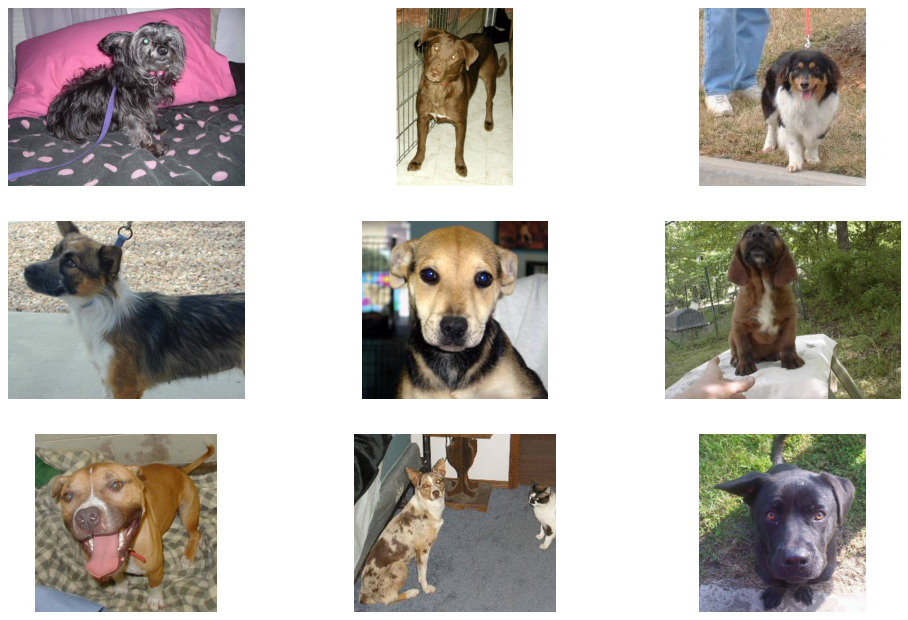

In [ ]:
from matplotlib import pyplot
from matplotlib.image import imread

from matplotlib.pyplot import figure
figure(figsize=(15, 10), dpi=80)

original_folder = 'train/'
for i in range(9):
  pyplot.subplot(330 + 1 + i)
  filename = original_folder + 'dog.' + str(i) + '.jpg'
  plt.axis("off")
  image = imread(filename)
  pyplot.imshow(image)
pyplot.show()

Всего у нас 25 тысяч изображений, но мы не будем использовать все тренировочные изображения, а ограничемся лишь некоторой их частью. При этом выберем тренировочный, валидационный и тестовый наборы данных.

In [ ]:
from os import listdir, path
len(listdir('/content/train'))

25000

## Подготовка данных

Мы будем использовать `ImageDataGenerator` из библиотеки Keras, чтобы сформировать из изображений необходимые нам наборы данных. Для этого создадим следующую структуру каталогов.
```
classifier_data
├── test
│   ├── cats
│   └── dogs
├── train
│   ├── cats
│   └── dogs
└── validation
    ├── cats
    └── dogs    
```

In [ ]:
home_dir = 'classifier_data'
os.makedirs(home_dir, exist_ok = True)
samples_list = ['train', 'test', 'validation']
categories_list = ['cats', 'dogs']

for sample_name in samples_list:
  for category_name in categories_list:
    os.makedirs(path.join(home_dir, sample_name, category_name), exist_ok = True)

 Отберем изображения в соответствующие папки.

In [ ]:
import shutil
# Сколько изображений каждого класса хотим взять
train_files_volume = 6000
validation_files_volume = 1000
test_files_volume = 1000

for item in listdir(original_folder):
  number = int(item.split('.')[1])
  name = item.split('.')[0]+'s'
  if number < train_files_volume:
    shutil.copy(path.join(original_folder, item), path.join('/content/classifier_data/train', name, item))
  if train_files_volume <= number < train_files_volume + validation_files_volume:
    shutil.copy(path.join(original_folder, item), path.join('/content/classifier_data/validation', name, item))
  if train_files_volume + validation_files_volume <= number < train_files_volume + validation_files_volume + test_files_volume:
    shutil.copy(path.join(original_folder, item), path.join('/content/classifier_data/test', name, item))    

Проверим, что все файлы на местах:

In [ ]:
print("Train:      котов {}, собак {}".format(len(listdir('/content/classifier_data/train/cats')), len(listdir('/content/classifier_data/train/dogs'))))
print("Validation: котов {}, собак {}".format(len(listdir('/content/classifier_data/validation/cats')), len(listdir('/content/classifier_data/validation/dogs'))))
print("Test:       котов {}, собак {}".format(len(listdir('/content/classifier_data/test/cats')), len(listdir('/content/classifier_data/test/dogs'))))


Train:      котов 6000, собак 6000
Validation: котов 1000, собак 1000
Test:       котов 1000, собак 1000


Зададим некоторые гиперпараметры

In [ ]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Activation, Dropout, Flatten, Dense
from keras import backend as K
from os import listdir

img_width, img_height = 150, 150 # ширина, высота изображений

train_data_dir = '/content/classifier_data/train' # директория с изображениями кошек и собак для последующего обучения модели
validation_data_dir = '/content/classifier_data/validation' # директория с изображениями для валидации модели
test_data_dir = '/content/classifier_data/test' # директория с изображениями для тестирования модели
nb_train_samples = train_files_volume * 2
nb_validation_samples = validation_files_volume * 2
nb_test_samples = test_files_volume * 2
batch_size = 32 # данные разбиваются на "пакеты" размером "batch_size"


Мы хотим обучить модель на сравнительно небольшом количестве данных. Но это количество можно увеличить с помощью аугментации, т.е. трансформации исходного изображения (изменения масштаба, сдвига, горизонтального отражения). Кроме этого аугментация позволяет уменьшить вероятность переобучения.


Воспользуемся `ImageDataGenerator` и командой `.flow()`. Мы будем использовать только некоторые преобразования в рамках аугментации. Документация по модулю [доступна тут.](https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/image/ImageDataGenerator)

Создадим отдельные генераторы для `train`, `validation` и `test`.


In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1. / 255,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)

train_generator = train_datagen.flow_from_directory(
    train_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 12000 images belonging to 2 classes.


In [ ]:
validation_datagen = ImageDataGenerator(rescale=1. / 255)
validation_generator = validation_datagen.flow_from_directory(
    validation_data_dir,
    target_size=(img_width, img_height),
    batch_size=batch_size,
    class_mode='binary')

Found 2000 images belonging to 2 classes.


In [ ]:
test_datagen = ImageDataGenerator(rescale=1. / 255)
test_generator = test_datagen.flow_from_directory(
    test_data_dir,
    target_size=(img_width, img_height),
    batch_size=nb_test_samples,
    class_mode='binary',
    shuffle=False) #Сохраняет последовательность файлов из папки

Found 2000 images belonging to 2 classes.


## Обучение и оценка модели

## Предсказания для тестовых данных из задания. 